In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
import numpy as np

def generate_time_series(batch_size, n_steps): # создает batch_size временных рядов длинной n_steps
  freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10)) # колебание 1
  series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20)) # колебание 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # шум
  return series[..., np.newaxis].astype(np.float32)

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [8]:
import keras

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020448709

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
]) # CNN 0.004

model =  keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
]) # RNN 0.014

model =  keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), # выход, будет иметь ту же длину последовательности что и вход
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
]) # Deep RNN 0.003

In [13]:
series = generate_time_series(1, n_steps + 1)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:],)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [14]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [16]:
model =  keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [17]:
Y_pred = model.predict(X_new) # 0.008 MSE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


In [23]:
Y = np.empty((10000, n_steps, 10)) # каждая цель является последовательностью из 10-мерных векторов

for step_ahead in range(1, 10 + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [33]:
model =  keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [36]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse]) # 0.006 MSE

In [37]:
class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
    self.layer_norm = keras.layers.LayerNormalization()
    self.activation = keras.activations.get(activation)

  def call(self, inputs, states):
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs] # выход и новый слой

In [41]:
model =  keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# LSTM

In [43]:
model =  keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [46]:
model =  keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True), # Gated Recurrent Unit
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
hisrory = model.fit(X_train, Y_train[:,3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

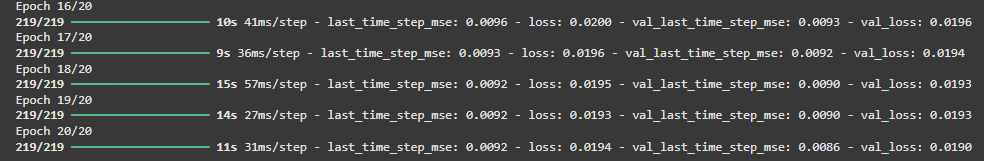

# WaveNet

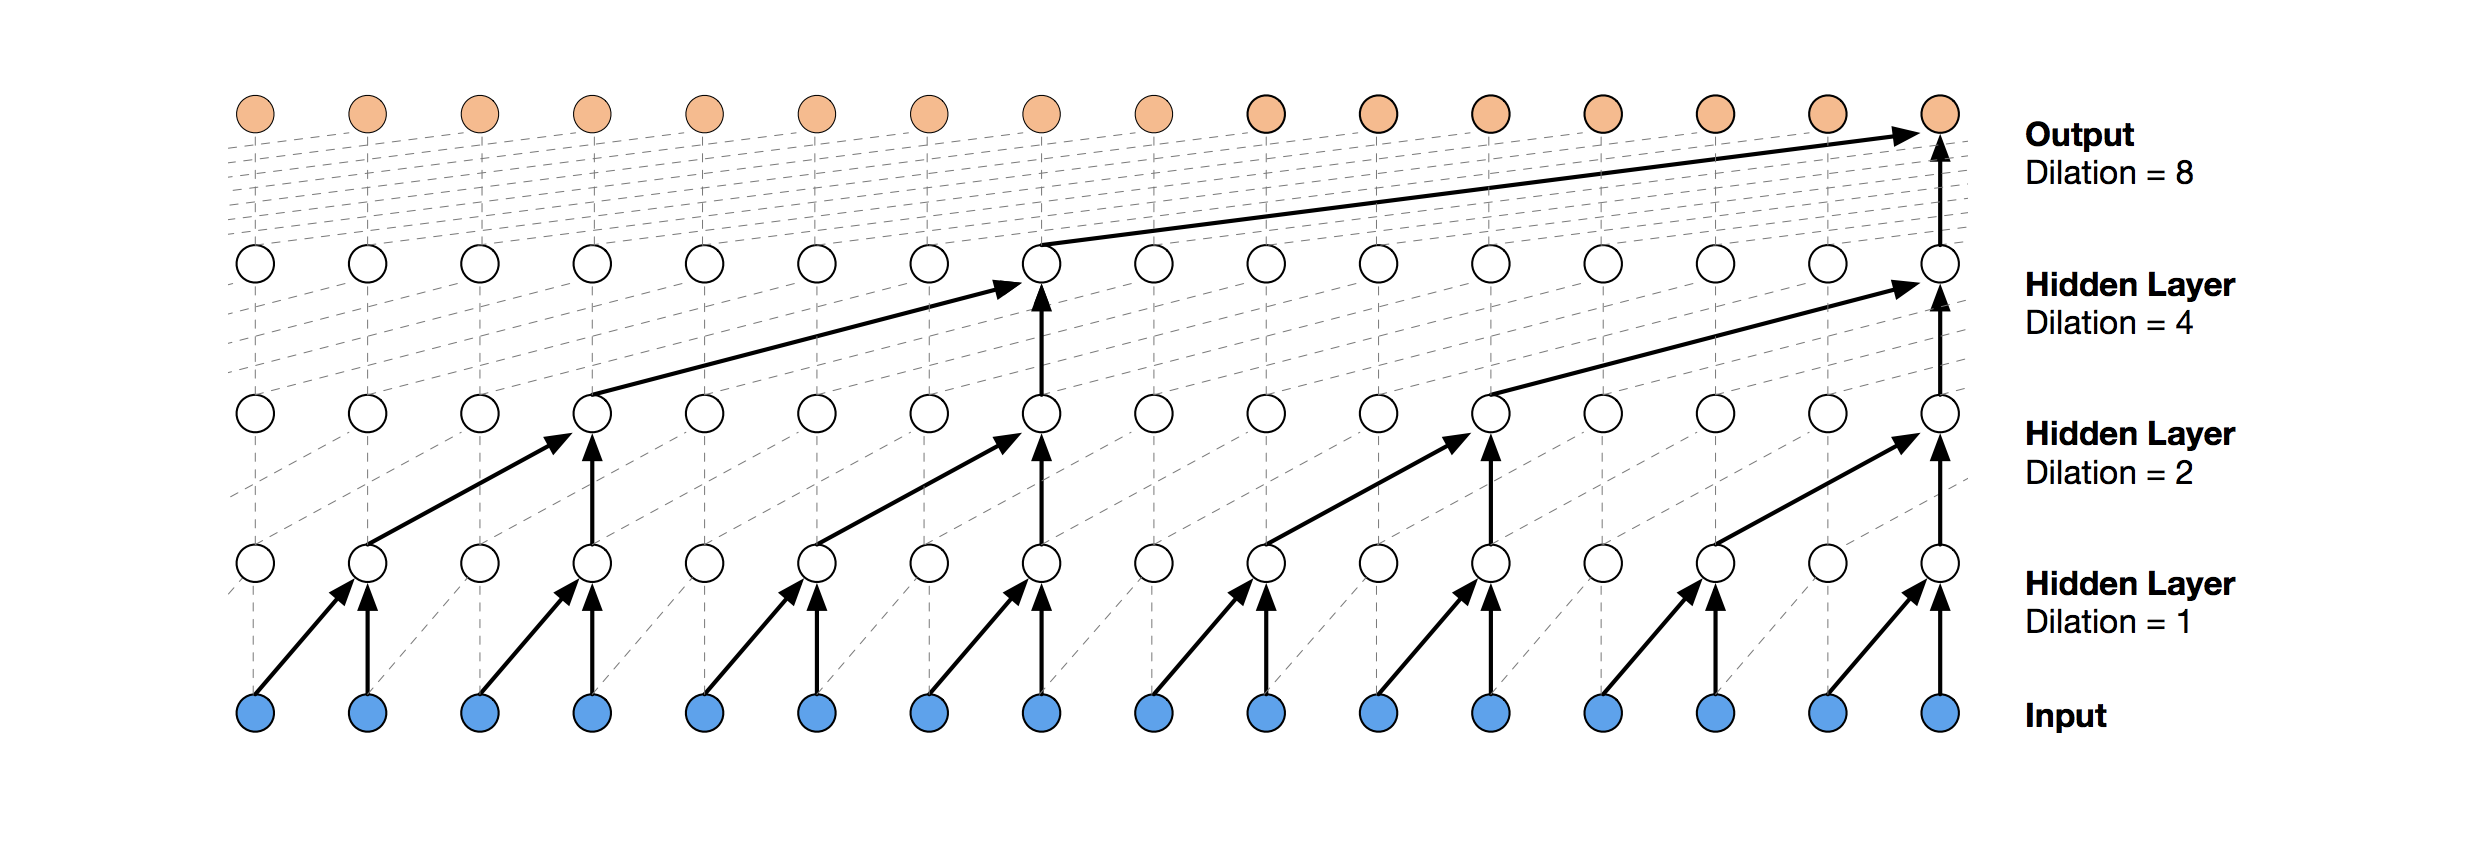

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
  model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))

model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
hisrory = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - last_time_step_mse: 0.0871 - loss: 0.0961 - val_last_time_step_mse: 0.0215 - val_loss: 0.0351
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - last_time_step_mse: 0.0202 - loss: 0.0337 - val_last_time_step_mse: 0.0179 - val_loss: 0.0304
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0161 - loss: 0.0290 - val_last_time_step_mse: 0.0143 - val_loss: 0.0267
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0139 - loss: 0.0265 - val_last_time_step_mse: 0.0126 - val_loss: 0.0251
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - last_time_step_mse: 0.0129 - loss: 0.0251 - val_last_time_step_mse: 0.0130 - val_loss: 0.0249
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0124 - loss: 0.0246 - val_last_time_step_mse: 0.0114 - val_loss: 0.0235
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0119 - loss: 0.0239 - val_las